In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np

import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from scipy.io import loadmat
from keras.utils import to_categorical
import itertools

import warnings
warnings.simplefilter('ignore')

In [ ]:
os.chdir("/content/drive/My Drive/Colab Notebooks/CV-Data")
!ls

mnist-original.mat


In [ ]:
def load_mnist_dataset():
    """
    Load MNIST-original dataset

    Returns:
    - mnist_data -- an array of arrays in the shape of (784,)
    - mnist_label -- an array of labels
    - classes -- array of labels classes(a set of labels)
    - shape -- shape of data item
    - channels_count -- channel count of data images
    """

    mnist = loadmat("/content/drive/My Drive/Colab Notebooks/CV-Data/mnist-original.mat")
    mnist_data = mnist["data"].T
    mnist_data = mnist_data.reshape(len(mnist_data), 28, 28, 1)
    mnist_label = mnist["label"][0]
    count = len(set(mnist_label))
    return mnist_data, mnist_label, count, (28, 28, 1)

In [ ]:
data, labels, classes_count, data_shape = load_mnist_dataset()

print("data shape: " + str(data.shape))
print("labels shape: " + str(labels.shape))
print("classes count: " + str(classes_count))

data shape: (70000, 28, 28, 1)
labels shape: (70000,)
classes count: 10


In [ ]:
#function for plotting image samples
def plot_images_sample(X, Y):
    plt.figure(figsize=(10,10))
    rand_indicies = np.random.randint(len(X), size=25)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        index = rand_indicies[i]
        plt.imshow(np.squeeze(X[index]), cmap=plt.cm.binary)
        plt.xlabel(Y[index])
    plt.show()

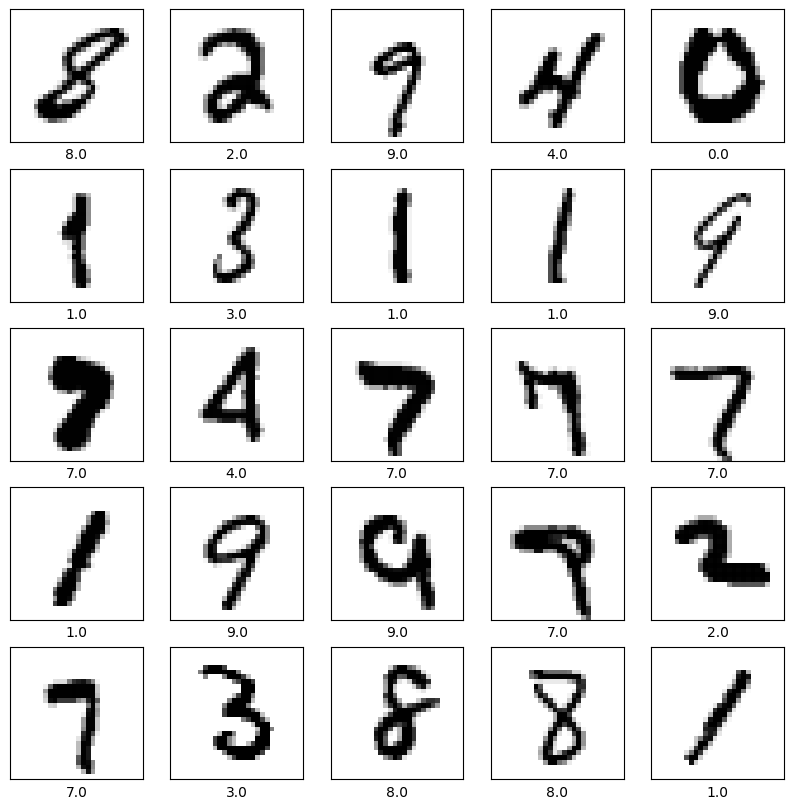

In [ ]:
# Draw plot for images sample
plot_images_sample(data, labels)

In [ ]:
def fe_data(df, target):
    #Scaling data and transform target to categorical
    #commonly used to convert integer-encoded labels into one-hot encoded vectors.
    #It is often used in the context of multi-class classification problems
    df = df / 255.
    target = to_categorical(target)
    return df, target

In [ ]:
# FE and data splitting
test_size_part = 0.1
x_train_orig, x_test_orig, y_train_orig, y_test_orig = train_test_split(data, labels, test_size=test_size_part, shuffle=True)
X_train, Y_train = fe_data(x_train_orig, y_train_orig)
X_test, Y_test = fe_data(x_test_orig, y_test_orig)

In [ ]:
# Model building
#(Dense = Fully-Connected)

model = models.Sequential([
      #layer1
        layers.Conv2D(8, kernel_size=(4, 4), strides=(1, 1), padding='same', activation='relu', input_shape=data_shape),
      #layer2
        layers.MaxPooling2D((8, 8), padding='same'),
      #layer3
        layers.Conv2D(16, kernel_size=(2, 2), strides=(1, 1), padding='same', activation='relu'),
      #layer4
        layers.MaxPooling2D((4, 4), padding='same'),
      #layer5
        layers.Flatten(),
      #Output layer
        layers.Dense(classes_count)
    ])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 8)         136       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 8)          0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 4, 4, 16)          528       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 1, 1, 16)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 10)               

In [ ]:
# Model training
epochs_num = 10
validation_split_part = 0.2
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=epochs_num, validation_split=validation_split_part)

Epoch 1/10
1575/1575 [==============================] - 18s 11ms/step - loss: 1.0003 - accuracy: 0.7007 - val_loss: 0.4682 - val_accuracy: 0.8594
Epoch 2/10
1575/1575 [==============================] - 16s 10ms/step - loss: 0.3998 - accuracy: 0.8750 - val_loss: 0.3433 - val_accuracy: 0.8929
Epoch 3/10
1575/1575 [==============================] - 16s 10ms/step - loss: 0.3241 - accuracy: 0.8983 - val_loss: 0.2816 - val_accuracy: 0.9130
Epoch 4/10
1575/1575 [==============================] - 17s 11ms/step - loss: 0.2770 - accuracy: 0.9140 - val_loss: 0.2600 - val_accuracy: 0.9210
Epoch 5/10
1575/1575 [==============================] - 18s 11ms/step - loss: 0.2468 - accuracy: 0.9224 - val_loss: 0.2349 - val_accuracy: 0.9252
Epoch 6/10
1575/1575 [==============================] - 16s 10ms/step - loss: 0.2239 - accuracy: 0.9300 - val_loss: 0.2099 - val_accuracy: 0.9337
Epoch 7/10
1575/1575 [==============================] - 17s 11ms/step - loss: 0.2057 - accuracy: 0.9351 - val_loss: 0.2000 -

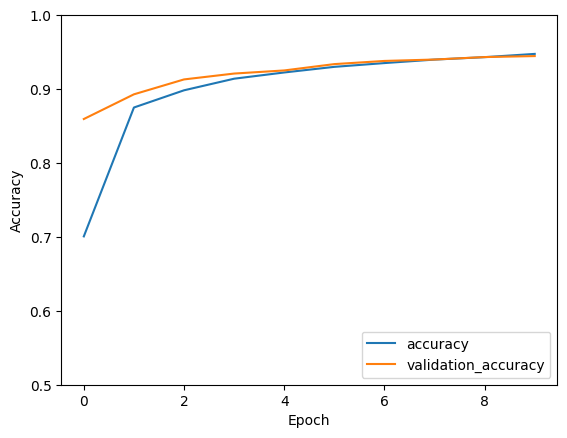

In [ ]:
# Draw plot for CNN training
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='validation_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Print test prediction accuracy
test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print("test accuracy: " + str(test_acc))

219/219 - 1s - loss: 0.1645 - accuracy: 0.9444 - 812ms/epoch - 4ms/step
test accuracy: 0.944428563117981


In [ ]:
#Digit prediction
def get_predictions(X_test):
    predictions = model.predict(X_test)
    predictions = np.argmax(predictions, axis=1)

    return predictions

219/219 [==============================] - 1s 4ms/step


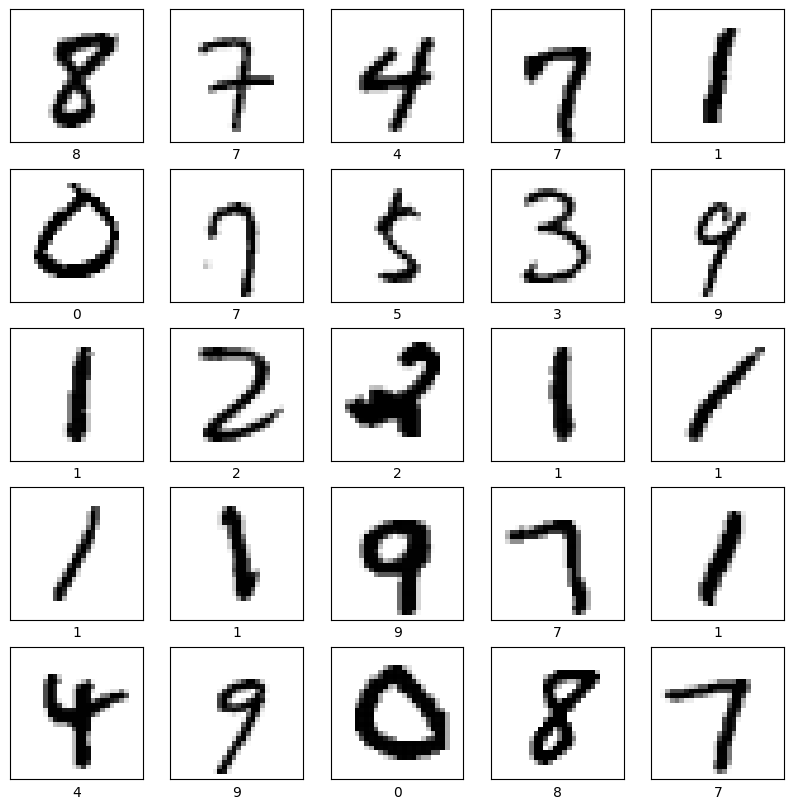

In [ ]:
# Predict and Display
predictions = get_predictions(X_test)
plot_images_sample(X_test, predictions)

In [ ]:
#Display Wrong Predictions
def pred_wrong_display_MNIST_dataset(X_test, predictions, Y_test):
    # Displays misclassified digits from MNIST dataset

    X_test_wrong = []
    predictions_wrong = []
    Y_test_pred = []
    for i in range(len(X_test)):
        Y_test_pred.append(np.argmax(Y_test[i]))
        if predictions[i] != Y_test_pred[i]:
            #print(i, predictions[i], Y_test_pred[i])
            X_test_wrong.append(X_test[i])
            predictions_wrong.append(predictions[i])

    plot_images_sample(X_test_wrong, predictions_wrong)

    print('Accuracy is', round(accuracy_score(Y_test_pred, predictions),3))

    return Y_test_pred

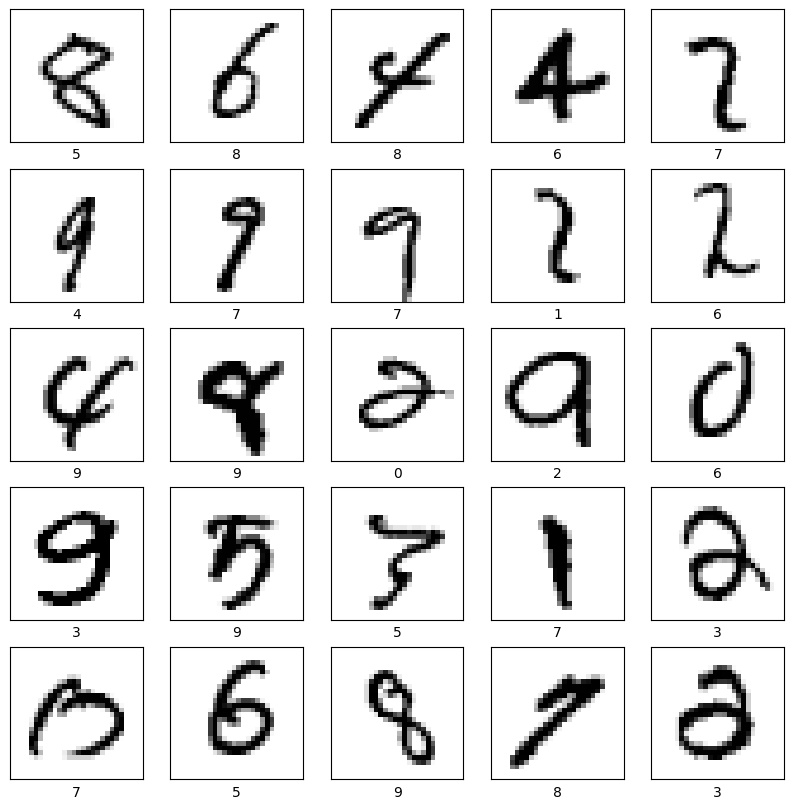

Accuracy is 0.944


In [ ]:
# Displays misclassified digits from MNIST
Y_test_pred = pred_wrong_display_MNIST_dataset(X_test, predictions, Y_test)

In [ ]:
#Plot Loss Error
def create_trace(x,y,ylabel,color):
        trace = go.Scatter(
            x = x,y = y,
            name=ylabel,
            marker=dict(color=color),
            mode = "markers+lines",
            text=x
        )
        return trace

def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = list(range(1,len(acc)+1))
    #define the traces
    trace_ta = create_trace(epochs,acc,"Training accuracy", "Green")
    trace_va = create_trace(epochs,val_acc,"Validation accuracy", "Red")
    trace_tl = create_trace(epochs,loss,"Training loss", "Blue")
    trace_vl = create_trace(epochs,val_loss,"Validation loss", "Magenta")
    fig = tools.make_subplots(rows=1,cols=2, subplot_titles=('Training and validation accuracy',
                                                             'Training and validation loss'))
    #add traces to the figure
    fig.append_trace(trace_ta,1,1)
    fig.append_trace(trace_va,1,1)
    fig.append_trace(trace_tl,1,2)
    fig.append_trace(trace_vl,1,2)
    #set the layout for the figure
    fig['layout']['xaxis'].update(title = 'Epoch')
    fig['layout']['xaxis2'].update(title = 'Epoch')
    fig['layout']['yaxis'].update(title = 'Accuracy', range=[0,1])
    fig['layout']['yaxis2'].update(title = 'Loss', range=[0,1])
    #plot
    iplot(fig, filename='accuracy-loss')

In [ ]:
import plotly.io as pio
pio.renderers.default = 'colab'

In [ ]:
plot_accuracy_and_loss(history)

In [ ]:
#Plot confusion matrix
def plot_cm(train, target_train):
    def plot_confusion_matrix(cm, classes,
                              normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

    # Predict the values from the validation dataset
    Y_pred = model.predict(train)
    # Convert predictions classes to one hot vectors
    Y_pred_classes = np.argmax(Y_pred,axis = 1)
    # Convert validation observations to one hot vectors
    Y_true = np.argmax(target_train,axis = 1)
    # compute the confusion matrix
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
    # plot the confusion matrix
    plot_confusion_matrix(confusion_mtx, classes = range(10))

1969/1969 [==============================] - 9s 5ms/step


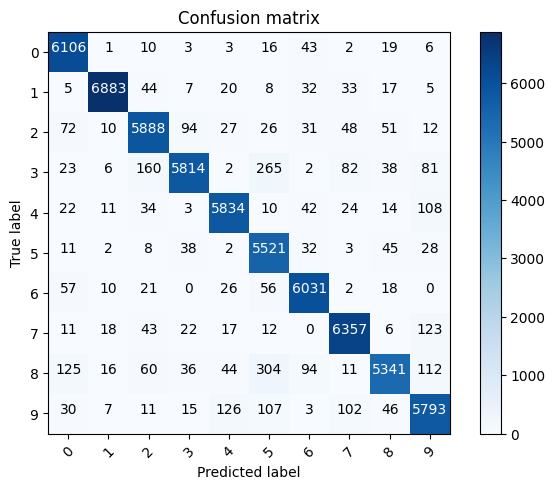

In [ ]:
#Confusion Matrix for training data
plot_cm(X_train, Y_train)

219/219 [==============================] - 1s 6ms/step


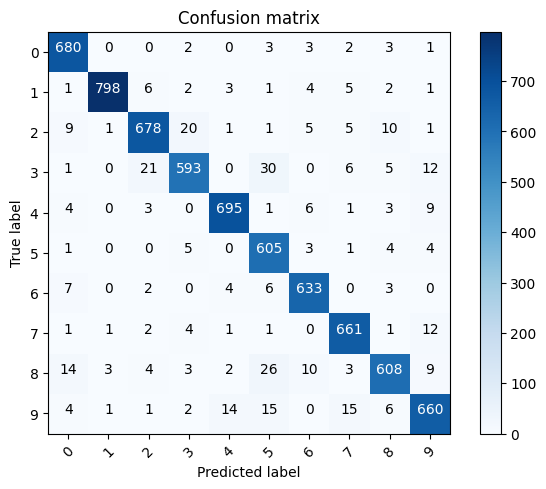

In [ ]:
#Confusion Matrix for test data
plot_cm(X_test, Y_test)

Considering that the accuracy of the model on the test data set was about 94.4%, it can be said that the network has a good performance.

However, this performance can be improved by doing things like increasing the number of network layers or increasing the epoch. For example, models with 11 hidden layers and epoch equal to 30 have been able to achieve a high accuracy of 99.6% on the test data set.